In [ ]:
# NOTE: This first script is too slow (takes more than 8 hours to complete 1 dataset). Speed improvements are made in the next script.
# Build CSV file from ../clean_data/*.csv

# Import dependencies
import pandas as pd
#pd.options.display.width = 0
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

import numpy as np
from timezonefinder import TimezoneFinder
from datetime import datetime, timedelta
from tqdm.std import tqdm

from get_weather_data_at_location_and_hour import *

# Import CSV file
file = "../clean_data/Stadium_Data.csv"
df = pd.read_csv(file)

# print(df.head())
# print(len(df))

tf = TimezoneFinder()

df_extended = pd.DataFrame()

for index, row in tqdm( df.iterrows(), total=len(df) ):
    #print(f"Row {index}: {row['ts']}, {row['latitude']}, {row['longitude']}")

    # Convert timestamp to local time
    dt_local = datetime.strptime(row['ts'], '%Y-%m-%dT%H:%M:%S')
    local_time_str = dt_local.strftime('%Y-%m-%dT%H:%M')

    # Figure out local time zone
    local_time_zone_str = tf.timezone_at(lng=row['longitude'], lat=row['latitude'])
    utc_time_str, timezone_diff_hrs = local_time_to_utc_str(local_time_str, local_time_zone_str)

    # Get the elevation at the given latitude and longitude
    elevation_meters = get_elevation_online(row['latitude'], row['longitude'])

    # Get weather data
    get_24hour_data = False # Get weather data for the specified local hour
    weather_data_dict = get_weather_data_at_location_and_hour(row['latitude'], row['longitude'], elevation_meters, utc_time_str, timezone_diff_hrs, get_24hour_data)

    # Convert the weather_data_dict to a pandas Series object
    weather_data_series = pd.Series(weather_data_dict)

    # Append the weather_data_series to the original row
    combined_series = pd.concat([row, weather_data_series], axis=0)

    # Append the combined_row to the new DataFrame
    df_extended = pd.concat([df_extended, combined_series.to_frame().T], axis=0) # to_frame().T converts the Series to a DataFrame row

df_extended.columns = df_extended.columns.str.lower()
print(df_extended)

# Save the DataFrame to a CSV file
df_extended.to_csv("../clean_data_extended/Stadium_Data_Extended.csv", index=False)


In [ ]:
# NOTE: This second script makes significant speed improvements (>10x) for the online query, by pulling query in 24-hour chunks.
# Build CSV file from ../clean_data/*.csv

# Import dependencies
import pandas as pd
#pd.options.display.width = 0
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

import numpy as np
from timezonefinder import TimezoneFinder
from datetime import datetime, timedelta
from tqdm.std import tqdm

from get_weather_data_at_location_and_hour import *

# csv_name = 'Stadium_Data'
csv_name = 'Science_Initiative_Building_Data'

# Import CSV file
file = f'../clean_data/{csv_name}.csv'
df = pd.read_csv(file)

# print(df.head())
# print(len(df))

tf = TimezoneFinder()

df_extended = pd.DataFrame()

running_chunk = False
row_counter = 0
get_elevation = True # Only get the elevation once per file (to improve speed)

for index, row in tqdm(df.iterrows(), total=len(df)):
    # Convert timestamp to local time
    dt_local = datetime.strptime(row['ts'], '%Y-%m-%dT%H:%M:%S')
    local_time_str = dt_local.strftime('%Y-%m-%dT%H:%M')

    # Figure out local time zone
    local_time_zone_str = tf.timezone_at(lng=row['longitude'], lat=row['latitude'])
    utc_time_str, timezone_diff_hrs = local_time_to_utc_str(local_time_str, local_time_zone_str)

    dt_utc = datetime.strptime(utc_time_str, '%Y-%m-%dT%H:%M')

    # Check if dt_utc is a new day, and if so, start a new 24-hour chunk
    if dt_utc.hour == 0:
        running_chunk = True
        row_counter = 0

        row_df_24 = pd.DataFrame()  # Initialize the DataFrame for the 24-hour chunk

        # Get the elevation at the given latitude and longitude
        if get_elevation:
            elevation_meters = get_elevation_online(row['latitude'], row['longitude'])
            get_elevation = False

        # Get weather data in 24-hour chunks
        get_24hour_data = True  # Get weather data for the entire UTC 24-hour day
        weather_data_dict_24 = get_weather_data_at_location_and_hour(row['latitude'], row['longitude'], elevation_meters, utc_time_str, timezone_diff_hrs, get_24hour_data)

        # Convert the weather_data_dict to a pandas DataFrame object
        weather_data_df_24 = pd.DataFrame(weather_data_dict_24)

    # Run this row by row until the 24-hour chunk is complete
    if running_chunk:
        row_counter += 1

        # Assemble rows for the 24-hour chunk
        row_df_24 = pd.concat([row_df_24, row.to_frame().T], axis=0)  # to_frame().T converts the Series to a DataFrame row

    # Once the 24-hour chunk is complete, append it to the new DataFrame
    if row_counter == 24:
        running_chunk = False
        row_counter = 0
        
        weather_data_df_24.index = row_df_24.index
        row_df_24 = pd.concat([row_df_24, weather_data_df_24], axis=1)

        # Append the combined_row to the new DataFrame
        df_extended = pd.concat([df_extended, row_df_24], axis=0)
    elif not running_chunk:
        # Get the elevation at the given latitude and longitude
        if get_elevation:
            elevation_meters = get_elevation_online(row['latitude'], row['longitude'])
            get_elevation = False

        # Get weather data
        get_24hour_data = False  # Get weather data for the specified local hour
        weather_data_dict = get_weather_data_at_location_and_hour(row['latitude'], row['longitude'], elevation_meters, utc_time_str, timezone_diff_hrs, get_24hour_data)

        # Convert the weather_data_dict to a pandas Series object
        weather_data_series = pd.Series(weather_data_dict)

        # Append the weather_data_series to the original row
        combined_series = pd.concat([row, weather_data_series], axis=0)

        # Append the combined_row to the new DataFrame
        df_extended = pd.concat([df_extended, combined_series.to_frame().T], axis=0)  # to_frame().T converts the Series to a DataFrame row

df_extended.columns = df_extended.columns.str.lower()
#print(df_extended)

df_extended = df_extended.drop(columns=['forecast', 'time_utc', 'time_local'])

# Save the DataFrame to a CSV file
df_extended.to_csv(f'../clean_data_extended/{csv_name}_Extended.csv', index=False)


In [3]:
import os
from build_extended_datafile import *

#csv_name = 'Science_Initiative_Building_Data'
#build_extended_datafile(csv_name)

# Check folder 'clean_data' for *.csv files and create a list of the filenames
csv_files_to_work = []
for file_name in sorted(os.listdir('../clean_data'), reverse = False):
    if file_name.endswith('.csv'):
        # Check if file is already present inside the 'clean_data_extended' folder
        if not os.path.isfile(f'../clean_data_extended/{file_name[:-4]}_Extended.csv'):
            csv_files_to_work.append(file_name[:-4]) # Remove the '.csv' extension

print(csv_files_to_work)
print(len(csv_files_to_work))

# Build the extended datafiles
for csv_name in csv_files_to_work:
    print(f':: -- Working on {csv_name}.csv ...')
    build_extended_datafile(csv_name)


['East_Campus_Data', 'West_Campus_Data']
2
:: -- Working on East_Campus_Data.csv ...


  0%|          | 0/29664 [00:00<?, ?it/s]


:: ** File East_Campus_Data_Extended.csv cannot be processed due to invalid entries...
:: -- Working on West_Campus_Data.csv ...


  0%|          | 0/29664 [00:00<?, ?it/s]

:: ** File West_Campus_Data_Extended.csv cannot be processed due to invalid entries...


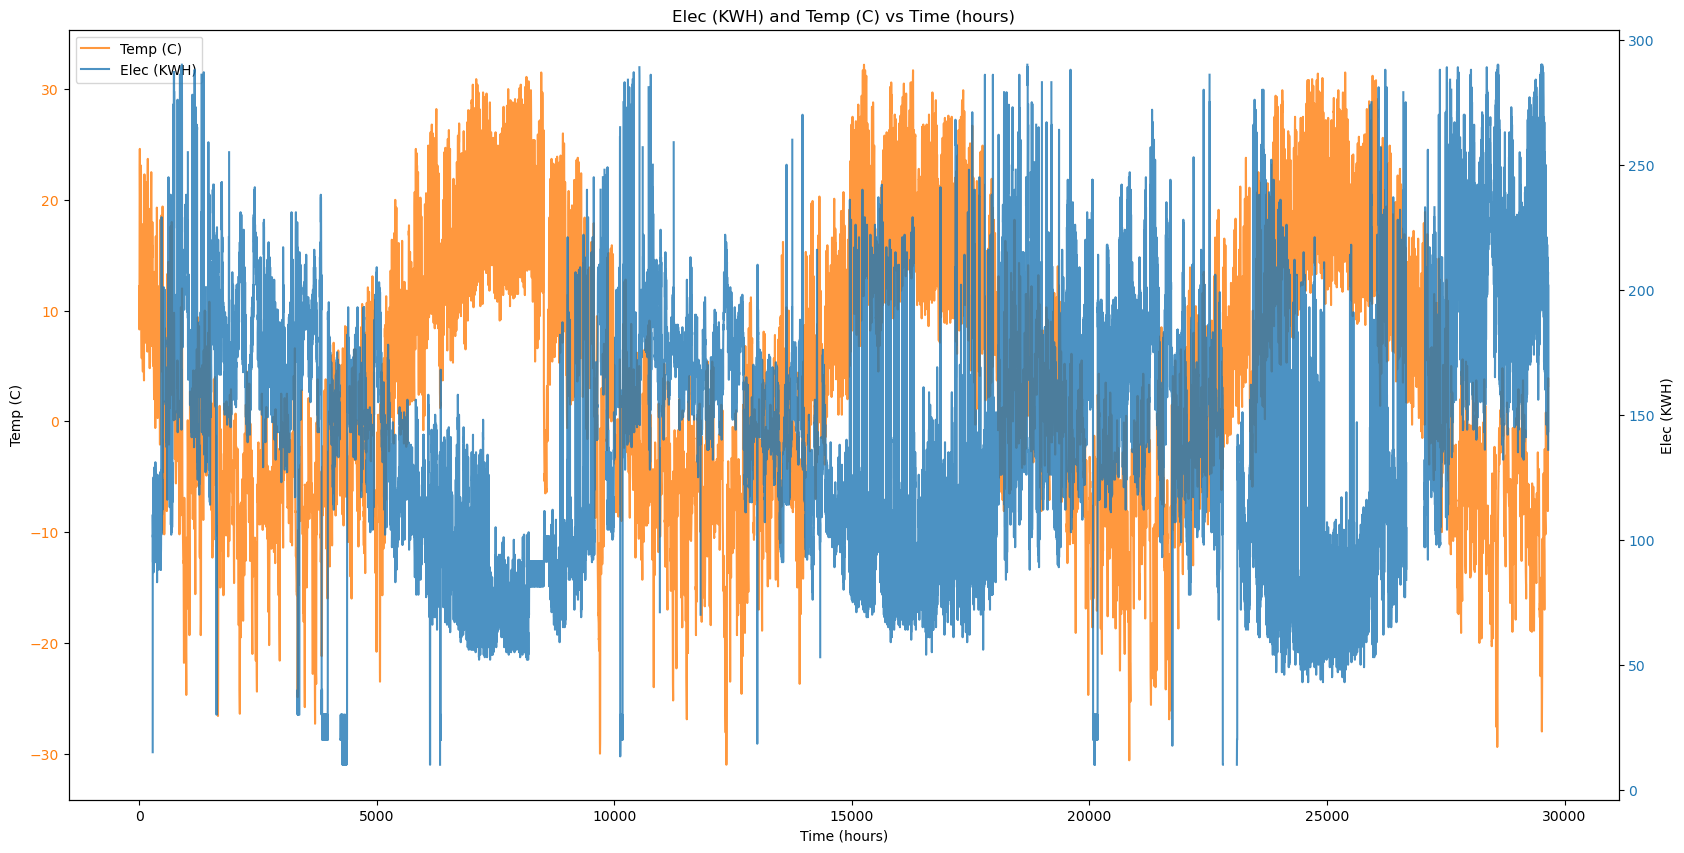

In [2]:
# %matplotlib widget
import pandas as pd
import matplotlib.pyplot as plt

# Import CSV file
file = "../clean_data_extended/Stadium_Data_Extended.csv"
df_extended = pd.read_csv(file)

#print(df_extended.tail(100))

# Convert the 'ts' column to datetime objects
df_extended['ts'] = pd.to_datetime(df_extended['ts'])

# Calculate the time difference in hours since the first data point
df_extended['hours_elapsed'] = (df_extended['ts'] - df_extended['ts'].iloc[0]).dt.total_seconds() / 3600

# Create a plot with a specified size
fig, ax1 = plt.subplots(figsize=(20, 10))

# Plot the present_elec_kwh column with respect to the hours_elapsed column
ax1.plot(df_extended['hours_elapsed'], df_extended['temp_c'], label='Temp (C)', color='#ff7f0e', alpha=0.8)
ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Temp (C)')
ax1.tick_params(axis='y', labelcolor='#ff7f0e')

# Create a twinx axis sharing the x-axis
ax2 = ax1.twinx()

# Plot the temp_c column with respect to the hours_elapsed column
ax2.plot(df_extended['hours_elapsed'], df_extended['present_elec_kwh'], label='Elec (KWH)', color='#1f77b4', alpha=0.8)
ax2.set_ylabel('Elec (KWH)')
ax2.tick_params(axis='y', labelcolor='#1f77b4')

# Set the title for the plot
plt.title('Elec (KWH) and Temp (C) vs Time (hours)')

# Create a single legend for both lines
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc='upper left')

# Show the plot
plt.show()
